In [160]:
import math
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn import metrics

In [175]:
def draw_cm( actual, predicted ):
    cm = metrics.confusion_matrix( actual, predicted)
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = actual.unique() , yticklabels = actual.unique() )
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

In [83]:
def get_hot_value(my_df):
    hot_results = my_df.copy()
    indexs = hot_results.idxmax(axis = 1)

    hot_results =  hot_results * 0

    for i in hot_results.index:  
      hot_results.at[i, indexs[i]] = 1

    return hot_results

In [43]:
import time
from tqdm import tqdm

In [44]:
import cv2
from google.colab.patches import cv2_imshow

In [45]:
path_base = '/content/drive/My Drive/Colab Notebooks/Project 7/'

In [46]:
images = np.load(path_base + 'images.npy')

# Loading

In [47]:
images.shape

(4750, 128, 128, 3)

In [48]:
labels = pd.read_csv(path_base + 'Labels.csv')

In [49]:
print(labels.head())
print()
labels.describe()

                       Label
0  Small-flowered Cranesbill
1  Small-flowered Cranesbill
2  Small-flowered Cranesbill
3  Small-flowered Cranesbill
4  Small-flowered Cranesbill



,Label
count,4750
unique,12
top,Loose Silky-bent
freq,654


## Image Visualization

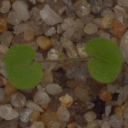

In [50]:
cv2_imshow(images[0])

In [51]:
print('The shape of image is: ', images[0].shape)
# Extracting the height and width of an image 
h, w = images[0].shape[:2] 
# Displaying the height and width 
print("Height = {},  Width = {}".format(h, w)) 

The shape of image is:  (128, 128, 3)
Height = 128,  Width = 128


# Image Preprocessing

(128, 128, 3)
[ 81  97 107]
Gaussian 3x


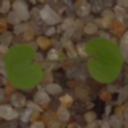

Gaussian 5x


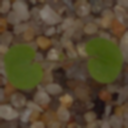

Gaussian 7x


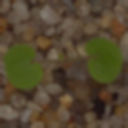

Gaussian 11x


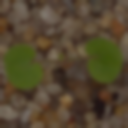

In [52]:
image_test = images[0] #cv2.resize(images[0], (256, 256))
print(image_test.shape)
print(image_test[20][64]) #printing a random cell to know it's format (in this case is a RGB 255, so I will need to normalize the array for Keras before using it)

print("Gaussian 3x")
cv2_imshow(cv2.GaussianBlur(image_test, (3, 3), 0))
print("Gaussian 5x")
cv2_imshow(cv2.GaussianBlur(image_test, (5, 5), 0))
print("Gaussian 7x")
cv2_imshow(cv2.GaussianBlur(image_test, (7, 7), 0))
print("Gaussian 11x")
cv2_imshow(cv2.GaussianBlur(image_test, (11, 11), 0))

In [53]:
import os.path
path_gaus = path_base + "images_gaus.npy"

# Choose 7 as the Gaussian multiplier

if not os.path.exists(path_gaus):
  images_gaus_1 = np.empty((images.shape[0], 128, 128, 3))
  
  range_ = range(images.shape[0])
  for i in tqdm(range_, position=0, leave=True):
    #images_gaus_1[i] = cv2.resize(images[i], (256, 256))
    images_gaus_1[i] = cv2.GaussianBlur(images[i], (7, 7), 0)

  images_gaus_1 = np.asarray(images_gaus_1) 
  np.save(path_gaus, images_gaus_1)
else:
  images_gaus_1 = np.load(path_gaus)

100%|██████████| 4750/4750 [00:03<00:00, 1389.03it/s]


# Labels to Dummies

In [54]:
types = pd.get_dummies(labels)
types.head()

,Label_Black-grass,Label_Charlock,Label_Cleavers,Label_Common Chickweed,Label_Common wheat,Label_Fat Hen,Label_Loose Silky-bent,Label_Maize,Label_Scentless Mayweed,Label_Shepherds Purse,Label_Small-flowered Cranesbill,Label_Sugar beet
0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,1,0


In [55]:
types.describe()

,Label_Black-grass,Label_Charlock,Label_Cleavers,Label_Common Chickweed,Label_Common wheat,Label_Fat Hen,Label_Loose Silky-bent,Label_Maize,Label_Scentless Mayweed,Label_Shepherds Purse,Label_Small-flowered Cranesbill,Label_Sugar beet
count,4750.000000,4750.000000,4750.000000,4750.000000,4750.000000,4750.000000,4750.000000,4750.000000,4750.000000,4750.000000,4750.000000,4750.000000
mean,0.055368,0.082105,0.060421,0.128632,0.046526,0.100000,0.137684,0.046526,0.108632,0.048632,0.104421,0.081053
std,0.228722,0.274554,0.238290,0.334827,0.210644,0.300032,0.344605,0.210644,0.311209,0.215119,0.305838,0.272945
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Model preparing

In [207]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

In [208]:
X = images_keras
y = types

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1)

In [209]:
# Like I write before, the images are RGB 255 so I will need to normalize it for Keras

path_keras = path_base + "images_keras.npy"

if not os.path.exists(path_keras):
  images_keras = np.empty((images_gaus_1.shape[0], 128, 128, 3))

  range_ = range(images_gaus_1.shape[0])
  for i in tqdm(range_, position=0, leave=True):
    # If not compatible expand the dimensions to match with the Keras Input
    images_keras[i] = np.expand_dims(images_gaus_1[i], axis = 0)
    images_keras[i] = images_keras[i]*1/255.0

  images_keras = np.asarray(images_keras)
  np.save(path_keras, images_keras)
else:
  images_keras = np.load(path_keras)

In [217]:
# Initialising the CNN classifier
classifier = Sequential()

classifier.add(Conv2D(64, (3, 3), input_shape = (128, 128, 3), activation = 'relu', padding = 'same'))

classifier.add(MaxPooling2D(pool_size = (3, 3)))

classifier.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))

classifier.add(MaxPooling2D(pool_size = (3, 3)))

classifier.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))

classifier.add(MaxPooling2D(pool_size = (3, 3)))

classifier.add(Flatten())

classifier.add(Dense(units = 1024, activation = 'relu'))

classifier.add(Dropout(0.5))

classifier.add(Dense(units = 256, activation = 'relu'))

#Using the column count int the dummies to build the classifier output
classifier.add(Dense(units = types.columns.size, activation = 'softmax'))

# Test 

In [264]:
# y_train 0
print(np.asanyarray(y_train)[0])

[0 0 0 0 0 0 0 0 1 0 0 0]


In [219]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [220]:
epochs = 40

history = classifier.fit(X_train, y_train.values, epochs=epochs, verbose = False)

hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

[]

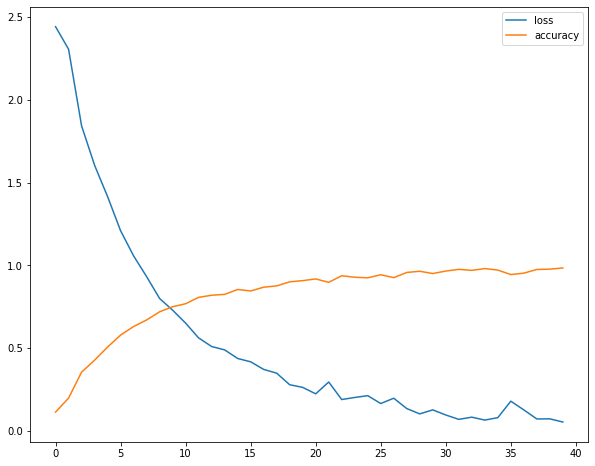

In [221]:
plt.plot(hist['loss'])
plt.plot(hist['accuracy'])
plt.legend(("loss" , "accuracy") , loc = 0)

plt.plot()

In [222]:
y_predict = classifier.predict(X_test)
   
# creating a list of column names 
column_values = types.columns
  
# creating the dataframe 
df_predict = pd.DataFrame(data = y_predict, index = y_test.index, columns = column_values)

In [231]:
df_predict = get_hot_value(df_predict)

print('Accuracy')
metrics.accuracy_score(y_test, df_predict)

Accuracy


0.7326315789473684

In [226]:
df_predict_label = df_predict.copy()
y_test_label = y_test.copy()

df_predict_label.reset_index(inplace=True)
y_test_label.reset_index(inplace=True)

df_predict_label = df_predict_label.drop('index', axis=1)
y_test_label = y_test_label.drop('index', axis=1)

df_predict_label = df_predict_label.idxmax(axis=1)
y_test_label = y_test_label.idxmax(axis=1)

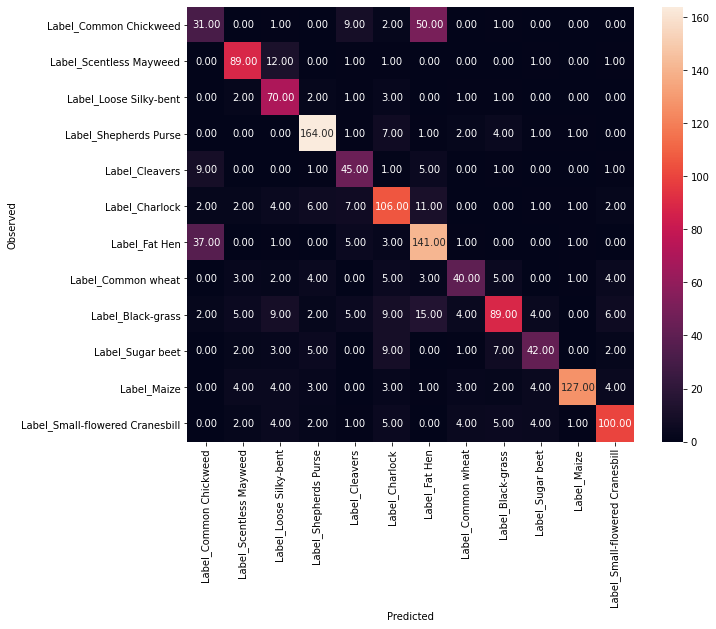

In [228]:
plt.rcParams["figure.figsize"] = (10,8)
draw_cm(y_test_label, df_predict_label)

#  x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]

In [262]:
view_index = 2

print(view_index)
print('Predict:\t'+ df_predict_label[view_index])
print('Test:\t\t'+ y_test_label[view_index])
print()

view_index = 3

print(view_index)
print('Predict:\t'+ df_predict_label[view_index])
print('Test:\t\t'+ y_test_label[view_index])
print()

view_index = 33

print(view_index)
print('Predict:\t'+ df_predict_label[view_index])
print('Test:\t\t'+ y_test_label[view_index])
print()

view_index = 36

print(view_index)
print('Predict:\t'+ df_predict_label[view_index])
print('Test:\t\t'+ y_test_label[view_index])
print()

view_index = 59

print(view_index)
print('Predict:\t'+ df_predict_label[view_index])
print('Test:\t\t'+ y_test_label[view_index])
print()

2
Predict:	Label_Scentless Mayweed
Test:		Label_Scentless Mayweed

3
Predict:	Label_Common Chickweed
Test:		Label_Common Chickweed

33
Predict:	Label_Black-grass
Test:		Label_Black-grass

36
Predict:	Label_Cleavers
Test:		Label_Cleavers

59
Predict:	Label_Shepherds Purse
Test:		Label_Shepherds Purse



# Validation

In [238]:
y_predict_val = classifier.predict(X_val)
   
# creating a list of column names 
column_values = types.columns
  
# creating the dataframe 
df_predict_val = pd.DataFrame(data = y_predict_val, index = y_val.index, columns = column_values)

In [263]:
df_predict_val = get_hot_value(df_predict_val)

print('Accuracy')
metrics.accuracy_score(y_val, df_predict_val)

Accuracy


0.7576668671076368

In [246]:
df_predict_val_label = df_predict_val.copy()
y_val_label = y_val.copy()

df_predict_val_label.reset_index(inplace=True)
y_val_label.reset_index(inplace=True)

df_predict_val_label = df_predict_val_label.drop('index', axis=1)
y_val_label = y_val_label.drop('index', axis=1)

df_predict_val_label = df_predict_val_label.idxmax(axis=1)
y_val_label = y_val_label.idxmax(axis=1)

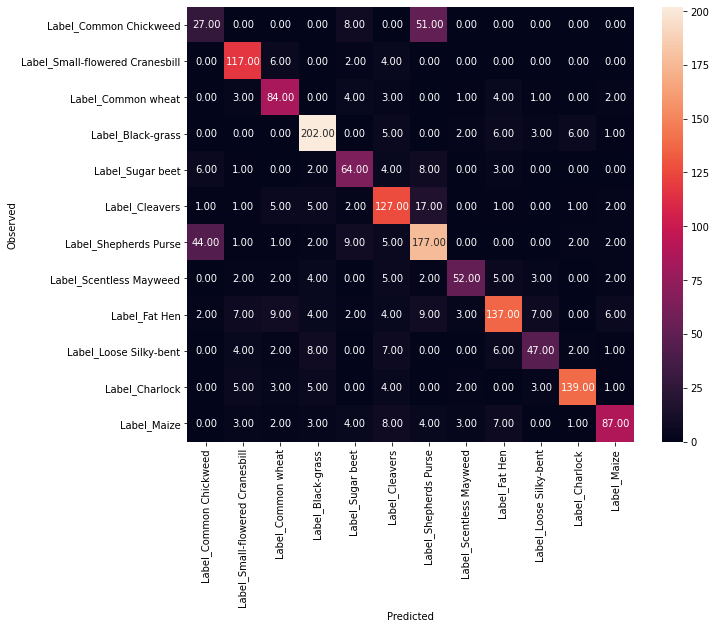

In [242]:
plt.rcParams["figure.figsize"] = (10,8)
draw_cm(y_val_label, df_predict_val_label)

#  x_val[2], x_val[3], x_val[33], x_val[36], x_val[59]

In [259]:
view_index = 2

print(view_index)
print('Predict:\t'+ df_predict_val_label[view_index])
print('Validation:\t'+ y_val_label[view_index])
print()

view_index = 3

print(view_index)
print('Predict:\t'+ df_predict_val_label[view_index])
print('Validation:\t'+ y_val_label[view_index])
print()

view_index = 33

print(view_index)
print('Predict:\t'+ df_predict_val_label[view_index])
print('Validation:\t'+ y_val_label[view_index])
print()

view_index = 36

print(view_index)
print('Predict:\t'+ df_predict_val_label[view_index])
print('Validation:\t'+ y_val_label[view_index])
print()

view_index = 59

print(view_index)
print('Predict:\t'+ df_predict_val_label[view_index])
print('Validation:\t'+ y_val_label[view_index])
print()

2
Predict:	Label_Black-grass
Validation:	Label_Common wheat

3
Predict:	Label_Common Chickweed
Validation:	Label_Common Chickweed

33
Predict:	Label_Black-grass
Validation:	Label_Loose Silky-bent

36
Predict:	Label_Charlock
Validation:	Label_Charlock

59
Predict:	Label_Cleavers
Validation:	Label_Maize

